# 04 — WISDM: feature extraction + train/test split + učenje modela (A vs B)

1) naloži `windows_*.npz` + `windows_*_meta.parquet`
2) izračuna značilnice (features) za vsako okno
3) zgradi `X` in `y`
4) naredi **train/test split** (random *in* opcijsko subject-wise)
5) nauči baseline modele:
- RandomForestClassifier (priporočeno)
- LogisticRegression (baseline)
6) izpiše metrike: Accuracy, Precision, Recall, F1, ROC AUC + confusion matrix
7) shrani:
- `prepared/features_*.parquet`
- `models/rf_*.joblib`
- `results/confusion_matrix_*.png`



## 0) Nastavitve
Nastavi `DATA_DIR` in izberi tag, ki se ujema z notebookom 03 (npr. `5s_50pct_purity80`).


In [4]:
from pathlib import Path
import numpy as np
import pandas as pd

DATA_DIR = Path(r"/Users/pikakriznar/Documents/1_letnik_MAG/UPK/Projekti/Razpoznava_hitenja_projekt/data/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset/wisdm-dataset")
assert DATA_DIR.exists(), f"DATA_DIR ne obstaja: {DATA_DIR}"

# Tag mora ustrezati shranjenim datotekam iz notebooka 03:
# npr. windows_5s_50pct_purity80.npz in windows_5s_50pct_purity80_meta.parquet
TAG = "5s_50pct_purity80"

WIN_PATH = DATA_DIR / "prepared" / f"windows_{TAG}.npz"
META_PATH = DATA_DIR / "prepared" / f"windows_{TAG}_meta.parquet"

assert WIN_PATH.exists(), f"Ne najdem oken: {WIN_PATH}"
assert META_PATH.exists(), f"Ne najdem meta: {META_PATH}"

OUT_DIR = DATA_DIR / "prepared"
RESULTS_DIR = DATA_DIR / "results"
MODELS_DIR = DATA_DIR / "models"
RESULTS_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)

print("WIN_PATH:", WIN_PATH)
print("META_PATH:", META_PATH)


WIN_PATH: /Users/pikakriznar/Documents/1_letnik_MAG/UPK/Projekti/Razpoznava_hitenja_projekt/data/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset/wisdm-dataset/prepared/windows_5s_50pct_purity80.npz
META_PATH: /Users/pikakriznar/Documents/1_letnik_MAG/UPK/Projekti/Razpoznava_hitenja_projekt/data/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset/wisdm-dataset/prepared/windows_5s_50pct_purity80_meta.parquet


## 1) Naloži okna in meta
Okna so `wins` oblike `(N, T, 3)`.


In [5]:
wins = np.load(WIN_PATH)["wins"]
meta = pd.read_parquet(META_PATH)

print("wins shape:", wins.shape)
print("meta shape:", meta.shape)
meta.head()


wins shape: (773, 100, 3)
meta shape: (773, 7)


,subject_id,start_idx,end_idx,start_ts,end_ts,label,purity
0,1600,0,100,2.519876e+14,2.519926e+14,1,1.0
1,1600,50,150,2.519901e+14,2.519951e+14,1,1.0
2,1600,100,200,2.519927e+14,2.519976e+14,1,1.0
3,1600,150,250,2.519952e+14,2.520002e+14,1,1.0
4,1600,200,300,2.519977e+14,2.520027e+14,1,1.0


## 2) Feature extraction
Značilnice po oknu (minimalen, dober set):
- mean/std/min/max za x,y,z
- magnitude (sqrt(x^2+y^2+z^2)): mean/std/min/max
- (opcijsko) frekvenčna energija magnitude v določenem pasu

Za začetek je set brez FFT pogosto dovolj dober.


In [6]:
def extract_features_from_windows(wins: np.ndarray, sampling_rate: int = 20, use_fft: bool = False) -> pd.DataFrame:
    # wins: (N, T, 3)
    x = wins[:,:,0]; y = wins[:,:,1]; z = wins[:,:,2]
    mag = np.sqrt(x**2 + y**2 + z**2)

    feats = {}
    for name, arr in [("x", x), ("y", y), ("z", z)]:
        feats[f"{name}_mean"] = arr.mean(axis=1)
        feats[f"{name}_std"]  = arr.std(axis=1)
        feats[f"{name}_min"]  = arr.min(axis=1)
        feats[f"{name}_max"]  = arr.max(axis=1)

    feats["mag_mean"] = mag.mean(axis=1)
    feats["mag_std"]  = mag.std(axis=1)
    feats["mag_min"]  = mag.min(axis=1)
    feats["mag_max"]  = mag.max(axis=1)

    if use_fft:
        # zelo osnovna frekvenčna energija magnitude
        # FFT po času za vsak window, vzamemo pozitivne frekvence
        # Energija v pasu 0.5–4 Hz (tipična frekvenca korakov)
        freqs = np.fft.rfftfreq(mag.shape[1], d=1.0/sampling_rate)  # (F,)
        fft_vals = np.fft.rfft(mag, axis=1)                         # (N, F)
        power = (np.abs(fft_vals) ** 2)

        band = (freqs >= 0.5) & (freqs <= 4.0)
        feats["fft_energy_0p5_4Hz"] = power[:, band].sum(axis=1)
        feats["fft_peak_freq"] = freqs[np.argmax(power[:, 1:], axis=1) + 1]  # ignoriraj DC

    return pd.DataFrame(feats)

SAMPLING_RATE = 20  # mora biti enako kot v notebooku 03
USE_FFT = True      # TODO: lahko nastaviš False, če želiš preprostejši baseline

X_df = extract_features_from_windows(wins, sampling_rate=SAMPLING_RATE, use_fft=USE_FFT)
X_df.head(), X_df.shape


(     x_mean     x_std      x_min     x_max    y_mean     y_std     y_min  \
 0 -1.707408  3.754923 -15.795654  6.010147  8.229062  7.848689 -6.569107   
 1 -1.651616  3.388637 -15.795654  5.757797  7.963412  7.724643 -5.964920   
 2 -1.751988  3.813674 -18.615417  5.757797  8.187352  7.860366 -6.113724   
 3 -1.633039  3.767530 -18.615417  4.595642  8.463151  7.699601 -6.113724   
 4 -1.141853  3.581151 -16.669891  8.137070  8.295156  7.697258 -7.046631   
 
        y_max    z_mean     z_std      z_min      z_max   mag_mean   mag_std  \
 0  19.613052 -0.781840  3.395726  -7.870834  13.642670  10.865490  6.357471   
 1  19.480194 -1.096644  3.409408  -9.889557  10.390198  10.583551  6.173481   
 2  19.552063 -1.152061  3.430030 -10.198944  14.020706  10.916729  6.352090   
 3  19.552063 -0.927556  3.625126 -10.198944  14.020706  11.069862  6.263381   
 4  19.512024 -0.976565  3.780738 -12.583710  10.594086  10.909266  6.198503   
 
     mag_min    mag_max  fft_energy_0p5_4Hz  fft_peak_

## 3) Zgradi dataset (X, y) + shrani features


In [7]:
y = meta["label"].astype(int).to_numpy()

dataset = X_df.copy()
dataset["label"] = y
dataset["subject_id"] = meta["subject_id"].astype(int).to_numpy()
dataset["start_ts"] = meta["start_ts"].to_numpy()
dataset["end_ts"] = meta["end_ts"].to_numpy()

feat_path = OUT_DIR / f"features_{TAG}.parquet"
dataset.to_parquet(feat_path, index=False)

print("Saved features:", feat_path)
dataset.head()


Saved features: /Users/pikakriznar/Documents/1_letnik_MAG/UPK/Projekti/Razpoznava_hitenja_projekt/data/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset/wisdm-dataset/prepared/features_5s_50pct_purity80.parquet


,x_mean,x_std,x_min,x_max,y_mean,y_std,y_min,y_max,z_mean,z_std,...,mag_mean,mag_std,mag_min,mag_max,fft_energy_0p5_4Hz,fft_peak_freq,label,subject_id,start_ts,end_ts
0,-1.707408,3.754923,-15.795654,6.010147,8.229062,7.848689,-6.569107,19.613052,-0.781840,3.395726,...,10.865490,6.357471,0.977497,24.557747,165638.568201,2.6,1,1600,2.519876e+14,2.519926e+14
1,-1.651616,3.388637,-15.795654,5.757797,7.963412,7.724643,-5.964920,19.480194,-1.096644,3.409408,...,10.583551,6.173481,1.076254,24.557747,151214.180529,2.6,1,1600,2.519901e+14,2.519951e+14
2,-1.751988,3.813674,-18.615417,5.757797,8.187352,7.860366,-6.113724,19.552063,-1.152061,3.430030,...,10.916729,6.352090,1.376420,29.975824,157862.622344,2.6,1,1600,2.519927e+14,2.519976e+14
3,-1.633039,3.767530,-18.615417,4.595642,8.463151,7.699601,-6.113724,19.552063,-0.927556,3.625126,...,11.069862,6.263381,1.376420,29.975824,152685.547626,2.6,1,1600,2.519952e+14,2.520002e+14
4,-1.141853,3.581151,-16.669891,8.137070,8.295156,7.697258,-7.046631,19.512024,-0.976565,3.780738,...,10.909266,6.198503,1.080016,27.168623,147820.085065,2.6,1,1600,2.519977e+14,2.520027e+14


## 4) Train/Test split


In [8]:
from sklearn.model_selection import train_test_split

FEATURE_COLS = [c for c in dataset.columns if c not in ["label", "subject_id", "start_ts", "end_ts"]]

X = dataset[FEATURE_COLS].to_numpy()
y = dataset["label"].to_numpy()
subjects = dataset["subject_id"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train label counts:", np.bincount(y_train))
print("Test label counts:", np.bincount(y_test))


Train: (618, 18) Test: (155, 18)
Train label counts: [309 309]
Test label counts: [78 77]


### 4.1) Subject-wise split
To simulira realno uporabo: model trenira na nekaterih ljudeh, testira na novih.


In [9]:
USE_SUBJECT_SPLIT = False  # TODO: nastavi True za subject-wise eval
TEST_SUBJECT_FRACTION = 0.2

if USE_SUBJECT_SPLIT:
    rng = np.random.default_rng(42)
    unique_subjects = np.unique(subjects)
    rng.shuffle(unique_subjects)
    n_test_subj = max(1, int(len(unique_subjects) * TEST_SUBJECT_FRACTION))
    test_subjects = set(unique_subjects[:n_test_subj])

    test_mask = np.array([s in test_subjects for s in subjects])
    X_train, X_test = X[~test_mask], X[test_mask]
    y_train, y_test = y[~test_mask], y[test_mask]

    print("Subject-wise split")
    print("Test subjects:", sorted(list(test_subjects))[:10], "...")
    print("Train:", X_train.shape, "Test:", X_test.shape)
    print("Train label counts:", np.bincount(y_train))
    print("Test label counts:", np.bincount(y_test))
else:
    print("USE_SUBJECT_SPLIT =", USE_SUBJECT_SPLIT, "(uporabljam random split zgoraj)")


USE_SUBJECT_SPLIT = False (uporabljam random split zgoraj)


## 5) Učenje modelov
Treniramo:
- Logistic Regression (hiter baseline)
- Random Forest (močan baseline za tabular features)

Opomba: Če imamo neuravnotežene razrede, uporabi `class_weight='balanced'`.


In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib
from pathlib import Path
import pandas as pd

# Paths
MODELS_DIR = Path(
    "/Users/pikakriznar/Documents/1_letnik_MAG/UPK/Projekti/"
    "Razpoznava_hitenja_projekt/data/"
    "wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset/"
    "wisdm-dataset/models"
)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path(
    "/Users/pikakriznar/Documents/1_letnik_MAG/UPK/Projekti/"
    "Razpoznava_hitenja_projekt/data/"
    "wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset/"
    "wisdm-dataset"
)
TAG = "5s_50pct_purity80"
FEATURES_PATH = DATA_DIR / "prepared" / f"features_{TAG}.parquet"

# 1) LogReg pipeline
logreg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

logreg_pipe.fit(X_train, y_train)

joblib.dump(
    logreg_pipe,
    MODELS_DIR / f"logreg_pipe_{TAG}.joblib"
)

# 2) Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

rf.fit(X_train, y_train)

joblib.dump(
    rf,
    MODELS_DIR / f"rf_{TAG}.joblib"
)

# 3) Feature cols (iz parquet)
df_feats = pd.read_parquet(FEATURES_PATH, engine="pyarrow")
feature_cols = [c for c in df_feats.columns if c not in ["label", "subject_id", "start_ts", "end_ts"]]

joblib.dump(
    feature_cols,
    MODELS_DIR / f"feature_cols_{TAG}.joblib"
)

print("✅ Models trained and saved:")
print(" -", MODELS_DIR / f"logreg_pipe_{TAG}.joblib")
print(" -", MODELS_DIR / f"rf_{TAG}.joblib")
print(" -", MODELS_DIR / f"feature_cols_{TAG}.joblib")


✅ Models trained and saved:
 - /Users/pikakriznar/Documents/1_letnik_MAG/UPK/Projekti/Razpoznava_hitenja_projekt/data/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset/wisdm-dataset/models/logreg_pipe_5s_50pct_purity80.joblib
 - /Users/pikakriznar/Documents/1_letnik_MAG/UPK/Projekti/Razpoznava_hitenja_projekt/data/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset/wisdm-dataset/models/rf_5s_50pct_purity80.joblib
 - /Users/pikakriznar/Documents/1_letnik_MAG/UPK/Projekti/Razpoznava_hitenja_projekt/data/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset/wisdm-dataset/models/feature_cols_5s_50pct_purity80.joblib


## 6) Evalvacija (Accuracy, Precision, Recall, F1, ROC AUC + confusion matrix)


In [34]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)

    # probas za ROC AUC (če obstaja)
    y_proba = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_test)
        # pretvori v [0,1] približno (sigmoid) za AUC
        y_proba = 1 / (1 + np.exp(-scores))

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    return {
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": auc
    }, y_pred

results = []
res_logreg, ypred_logreg = evaluate_model("LogisticRegression", logreg, X_test, y_test)
res_rf, ypred_rf = evaluate_model("RandomForest", rf, X_test, y_test)
results.extend([res_logreg, res_rf])

results_df = pd.DataFrame(results).sort_values("f1", ascending=False)
results_df


,model,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression,0.993548,1.0,0.987013,0.993464,0.992840
1,RandomForest,0.993548,1.0,0.987013,0.993464,0.999667


### 6.1) Confusion matrix za najboljši model


<Figure size 640x480 with 0 Axes>

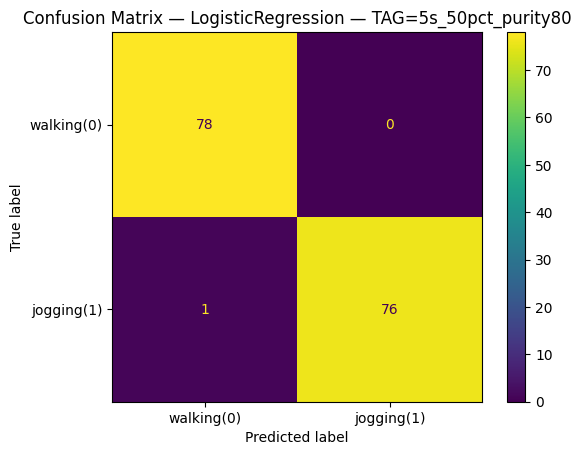

Saved: /Users/pikakriznar/Documents/1_letnik_MAG/UPK/Projekti/Razpoznava_hitenja_projekt/data/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset/wisdm-dataset/results/confusion_matrix_LogisticRegression_5s_50pct_purity80.png


<Figure size 640x480 with 0 Axes>

In [35]:
best_name = results_df.iloc[0]["model"]
best_model = rf if best_name == "RandomForest" else logreg

y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=["walking(0)", "jogging(1)"])
plt.figure()
disp.plot()
plt.title(f"Confusion Matrix — {best_name} — TAG={TAG}")
plt.show()

cm_path = RESULTS_DIR / f"confusion_matrix_{best_name}_{TAG}.png"
plt.figure()
disp.plot()
plt.title(f"Confusion Matrix — {best_name} — TAG={TAG}")
plt.savefig(cm_path, bbox_inches="tight", dpi=200)
plt.close()

print("Saved:", cm_path)


Saved: /Users/pikakriznar/Documents/1_letnik_MAG/UPK/Projekti/Razpoznava_hitenja_projekt/data/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset/wisdm-dataset/results/roc_curve_LogisticRegression_5s_50pct_purity80.png


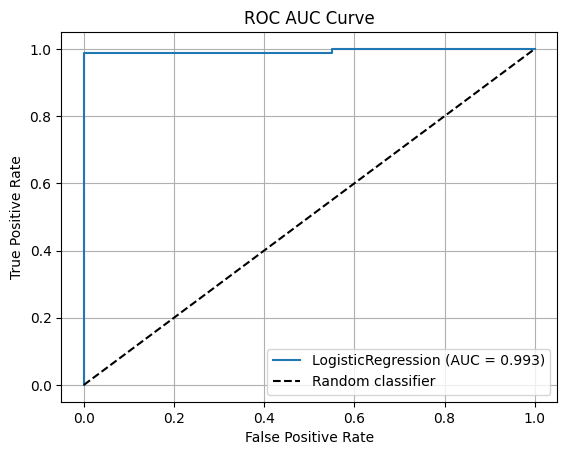

Saved: /Users/pikakriznar/Documents/1_letnik_MAG/UPK/Projekti/Razpoznava_hitenja_projekt/data/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset/wisdm-dataset/results/roc_curve_RandomForest_5s_50pct_purity80.png


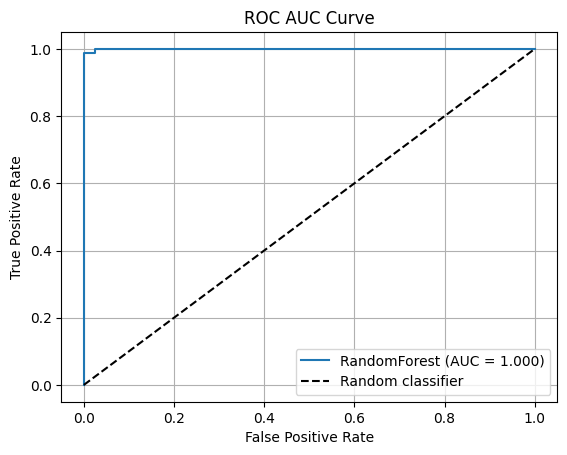

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(model, X_test, y_test, model_name="Model", tag="", results_dir=None):
    # Verjetnosti za pozitivni razred (jogging = 1)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        scores = model.decision_function(X_test)
        y_score = 1 / (1 + np.exp(-scores))  # sigmoid

    # ROC krivulja
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc = roc_auc_score(y_test, y_score)

    plt.figure()
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC AUC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)

    # Shrani sliko, če je podana mapa
    if results_dir is not None:
        out_path = results_dir / f"roc_curve_{model_name.replace(' ', '')}_{tag}.png"
        plt.savefig(out_path, bbox_inches="tight", dpi=200)
        print("Saved:", out_path)

    plt.show()


# Primer uporabe (enako kot confusion matrix):
plot_roc_curve(
    logreg,
    X_test,
    y_test,
    model_name="LogisticRegression",
    tag=TAG,
    results_dir=RESULTS_DIR
)

plot_roc_curve(
    rf,
    X_test,
    y_test,
    model_name="RandomForest",
    tag=TAG,
    results_dir=RESULTS_DIR
)


## 7) Shrani model


In [37]:
import joblib

model_path = MODELS_DIR / f"{best_name.lower()}_{TAG}.joblib"
joblib.dump(best_model, model_path)
print("Saved model:", model_path)


Saved model: /Users/pikakriznar/Documents/1_letnik_MAG/UPK/Projekti/Razpoznava_hitenja_projekt/data/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset/wisdm-dataset/models/logisticregression_5s_50pct_purity80.joblib


## 8) Kratek komentar


In [38]:
print(results_df.to_string(index=False))


             model  accuracy  precision   recall       f1  roc_auc
LogisticRegression  0.993548        1.0 0.987013 0.993464 0.992840
      RandomForest  0.993548        1.0 0.987013 0.993464 0.999667


#### NOTE TO SELF

**Metrike**

- Accuracy ≈ 0.994

        → skoraj vsa okna so pravilno klasificirana.

- Precision = 1.0

        → vsako okno, ki ga model označi kot jogging, je res jogging (ni false positive).

- Recall ≈ 0.987

        → model ujame skoraj vse jogging primere (zgreši 1 primer).

- F1 ≈ 0.993

        → zelo dobra uravnoteženost med precision in recall.

- ROC AUC ≈ 0.993–0.999

        → razredi so zelo dobro ločeni v feature prostoru.


To ni “sumljivo” v slabem smislu:

✔️ Aktivnosti so zelo različne

Walking vs jogging imata:

- različne amplitude,

- različno frekvenco korakov,

- različno energijo signala.

Značilnice (RMS, std, FFT energija) so zelo informativne.

✔️ Okna so čista (purity = 0.80)

- odstranili smo prehodna okna,

- model se uči na jasnih primerih.

✔️ Uporabljamo window-level učenje

- ne uči se na šumu posameznih vzorcev,

- ampak na stabilnih 5-sekundnih segmentih.

✔️ Tudi Logistic Regression deluje skoraj enako kot RF

- To je zelo pomembno:

                če preprost linearni model doseže tak rezultat, pomeni, da so razredi res dobro ločeni.

To je pozitivna validacija tvojih features, ne “overfitting alarm”.